## Setting up:

In [48]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from scipy.spatial.distance import cdist
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, train_test_split, GroupShuffleSplit
import csv

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
from oggm import cfg, utils, workflow, tasks
import logging
import geopandas as gpd
import xarray as xr

import config
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.geodata import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
seed_all(config.SEED)

# in case no memory
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

custom_working_dir = '../../../data/OGGM/'

In [50]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('rgi_id.v6', inplace=True)
rgi_df.head(2)

,short_name,full_name,sgi-id,rgi_id.v7,Issue
rgi_id.v6,,,,,
RGI60-11.02764,adler,Adler,B56/03,RGI2000-v7.0-G-11-01075,False
RGI60-11.02285,albigna,Albigna,NaN,RGI2000-v7.0-G-11-02309,True


In [51]:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset_all.csv')
rgis = data_glamos.RGIId.unique()
all_gl = list(data_glamos.GLACIER.unique())
data_glamos.head(2)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,slope,dis_from_border,topo,hugonnet_dhdt,consensus_ice_thickness,millan_ice_thickness,millan_v,millan_vx,millan_vy,snowslide_1m
0,2006,adler_28,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,...,0.340053,120.0,3039.0,-1.504815,43.181839,37.110600,3.591626,3.445628,1.013618,1.0
1,2006,adler_55,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,...,0.219036,30.0,3091.0,-0.970061,41.090096,8.961324,0.975349,-0.948907,-0.058481,1.0


In [52]:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_direct_save)
]
glDirect.sort()

data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

glacier_list = list(data_glamos.GLACIER.unique())
glacier_list.sort()
glacier_list

['adler',
 'albigna',
 'aletsch',
 'allalin',
 'basodino',
 'claridenL',
 'claridenU',
 'corbassiere',
 'corvatsch',
 'findelen',
 'forno',
 'gietro',
 'gorner',
 'gries',
 'hohlaub',
 'joeri',
 'limmern',
 'morteratsch',
 'murtel',
 'oberaar',
 'otemma',
 'pers',
 'pizol',
 'plainemorte',
 'plattalva',
 'rhone',
 'sanktanna',
 'schwarzbach',
 'schwarzberg',
 'sexrouge',
 'silvretta',
 'taelliboden',
 'tortin',
 'tsanfleuron']

## Testing with SGI:

In [53]:
glacierName = 'rhone'
sgi_id = rgi_df[rgi_df.short_name == glacierName]['sgi-id'].values[0].strip()
rgi_id = rgi_df[rgi_df.short_name == glacierName].index[0]
sgi_id_ref = reformat_SGI_id(sgi_id)

# Load the shapefile
shapefile_path = "../../../data/GLAMOS/topo/SGI_2016_glaciers_copy.shp"
gdf_shapefiles = gpd.read_file(shapefile_path)
gdf_mask_gl = gdf_shapefiles[gdf_shapefiles.Name == 'Rhonegletscher']

# open a grid file
path_aspect = path_SGI_topo + 'aspect/'
path_slope = path_SGI_topo + 'slope/'
path_DEM = path_SGI_topo + 'dem_HR/'
path_outline = path_SGI_topo + 'outline/lv95/'

aspect_gl = [f for f in os.listdir(path_aspect) if sgi_id_ref in f][0]
slope_gl = [f for f in os.listdir(path_slope) if sgi_id_ref in f][0]
dem_gl = [f for f in os.listdir(path_DEM) if sgi_id_ref in f][0]
outline_gl = [f for f in os.listdir(path_outline) if sgi_id_ref in f][0]

metadata_aspect, grid_data_aspect = load_grid_file(path_aspect + aspect_gl)
metadata_slope, grid_data_slope = load_grid_file(path_slope + slope_gl)
metadata_dem, grid_data_dem = load_grid_file(path_DEM + dem_gl)

# convert to xarray
aspect = convert_to_xarray(grid_data_aspect, metadata_aspect)
slope = convert_to_xarray(grid_data_slope, metadata_slope)
dem = convert_to_xarray(grid_data_dem, metadata_dem)

# Add glacier outline to the xarray
glacier_outline = draw_glacier_outline(aspect, path_outline + outline_gl)

dataset = xr.Dataset({
    "aspect": aspect,
    "slope": slope,
    "dem": dem,
    "glacier_outline": glacier_outline
})

# Transform the coordinates to WGS84
aspect_wgs84 = transform_xarray_coords_lv95_to_wgs84(aspect).transpose()
slope_wgs84 = transform_xarray_coords_lv95_to_wgs84(slope).transpose()
dem_wgs84 = transform_xarray_coords_lv95_to_wgs84(dem).transpose()
glacier_outline_wgs84 = transform_xarray_coords_lv95_to_wgs84(
    glacier_outline).transpose()

# Combine into a Dataset
dataset_wgs84 = xr.Dataset({
    "aspect": aspect_wgs84,
    "slope": slope_wgs84,
    "dem": dem_wgs84,
    "glacier_outline": glacier_outline_wgs84
})

gl_coordinates = xyzn_to_dataframe(path_outline + outline_gl)

# Transform gl_coordinates to WGS84
gl_coordinates_wgs84 = LV95toWGS84(gl_coordinates)

ncols: 385, nrows: 844
(844, 385)
ncols: 385, nrows: 844
(844, 385)
ncols: 385, nrows: 844
(844, 385)


### Plot SGI data:

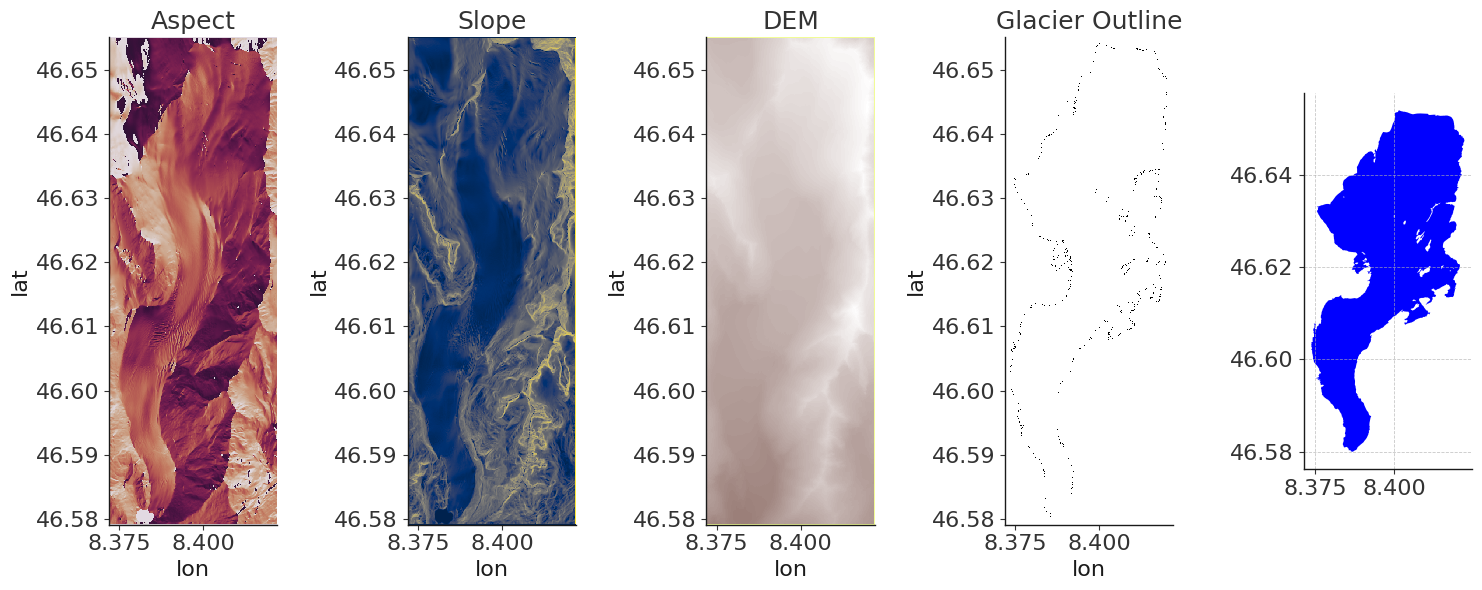

In [54]:
# plot aspect and slope, and dem
fig, axs = plt.subplots(1, 5, figsize=(15, 6))
dataset_wgs84.aspect.plot(ax=axs[0],
                          cmap='twilight_shifted',
                          add_colorbar=False)
dataset_wgs84.slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
dataset_wgs84.dem.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
dataset_wgs84.glacier_outline.plot(ax=axs[3],
                                   cmap='binary',
                                   add_colorbar=False)

gdf_mask_gl.plot(ax=axs[4], color='blue')

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier Outline")
plt.tight_layout()

### Mask over glacier outline:

#### Using geopandas:

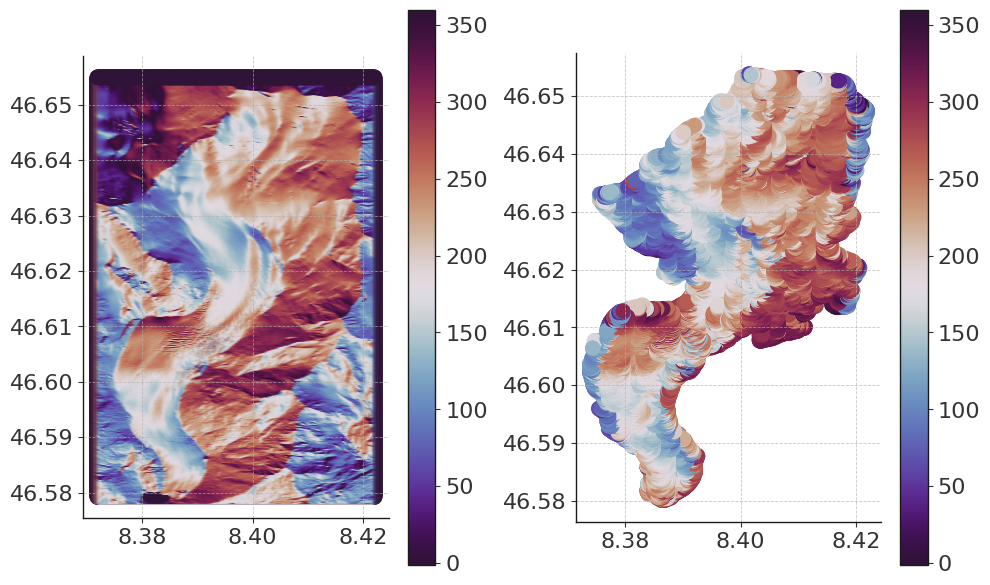

In [55]:
gdf = xarray_to_geodataframe(dataset_wgs84, 'aspect')
# Clip the glacier aspect data to the glacier mask
masked_aspect = gdf.clip(gdf_mask_gl.geometry)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
gdf.plot(column='value', cmap='twilight_shifted', legend=True, ax=axs[0])

# View the masked data
masked_aspect.plot(column='value',
                   cmap='twilight_shifted',
                   legend=True,
                   ax=axs[1])
plt.tight_layout()

#### Using xarray directly:

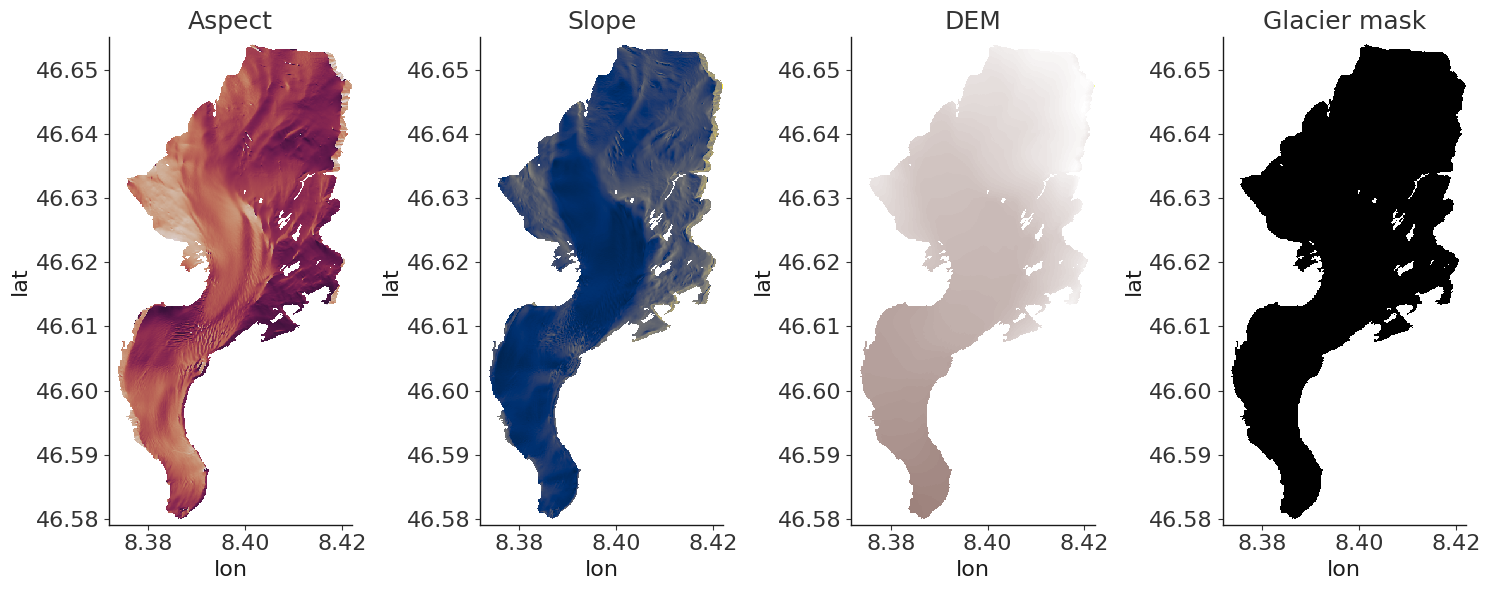

In [56]:
mask, masked_aspect = extract_topo_over_outline(aspect_wgs84, gdf_mask_gl)
mask, masked_slope = extract_topo_over_outline(slope_wgs84, gdf_mask_gl)
mask, masked_dem = extract_topo_over_outline(dem_wgs84, gdf_mask_gl)

# Create new dataset
ds = xr.Dataset({
    "masked_aspect": masked_aspect,
    "masked_slope": masked_slope,
    "masked_elev": masked_dem,
    "glacier_mask": mask
})

glacier_indices = np.where(ds['glacier_mask'].values == 1)

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted', add_colorbar=False)
ds.masked_slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
ds.masked_elev.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
ds.glacier_mask.plot(ax=axs[3], cmap='binary', add_colorbar=False)

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

## Create monthly SGI grids:

In [57]:
def create_glacier_grid_SGI(rgi_id, ds, glacier_indices, years = range(1951, 2023)):
    # Glacier mask as boolean array:
    gl_mask_bool = ds['glacier_mask'].values.astype(bool)
    lon, lat = glacier_indices[0], glacier_indices[1]
        
    # Create a DataFrame
    data_grid = {
        'RGIId': [rgi_id] * len(ds.masked_elev.values[gl_mask_bool]),
        'POINT_LAT': lat,
        'POINT_LON': lon,
        'aspect': ds.masked_aspect.values[gl_mask_bool],
        'slope': ds.masked_slope.values[gl_mask_bool],
        'topo': ds.masked_elev.values[gl_mask_bool],
    }
    df_grid = pd.DataFrame(data_grid)

    # Match to WGMS format:
    df_grid['POINT_ID'] = np.arange(1, len(df_grid) + 1)
    df_grid['N_MONTHS'] = 12
    df_grid['POINT_ELEVATION'] = df_grid[
        'topo']  # no other elevation available
    df_grid['POINT_BALANCE'] = 0  # fake PMB for simplicity (not used)
    num_rows_per_year = len(df_grid)
    # Repeat the DataFrame num_years times
    df_grid = pd.concat([df_grid] * len(years), ignore_index=True)
    # Add the 'year' and date columns to the DataFrame
    df_grid['YEAR'] = np.repeat(
        years, num_rows_per_year
    )  # 'year' column that has len(df_grid) instances of year
    df_grid['FROM_DATE'] = df_grid['YEAR'].apply(lambda x: str(x) + '1001')
    df_grid['TO_DATE'] = df_grid['YEAR'].apply(lambda x: str(x + 1) + '0930')
    return df_grid

In [58]:
df_grid = create_glacier_grid_SGI(rgi_id, ds, glacier_indices, years = range(1951, 2023))
# Add metadata that is not in WGMS dataset
df_grid["PERIOD"] = "annual"
df_grid['GLACIER'] = glacierName

In [59]:
dataset_grid = mbm.Dataset(data=df_grid,
                                   region_name='CH',
                                   data_path=path_PMB_GLAMOS_csv)
# Add climate data:
era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'
dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                    geopotential_data=geopotential_data,
                                    change_units=True)

# Add potential clear sky radiation:
print('Adding potential clear sky radiation')
dataset_grid.get_potential_rad(path_direct_save)

KeyboardInterrupt: 

## Compute grids for all glaciers:

In [ ]:
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]
voi_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
    "topo",
]

#### Test glaciers:

In [ ]:
RUN = False
# Add climate variables and convert to monthly
if RUN:
    emptyfolder(path_glacier_grid)
    # Glaciers used for testing
    rest_gl = [
        'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
        'joeri', 'corvatsch', 'tsanfleuron'
    ]
    for glacierName in tqdm(rest_gl, desc='Processing glaciers'):
        print('\n-----------------------------------')
        print(glacierName)
        rgi_gl = rgi_df[rgi_df.short_name == glacierName].index.values[0]
        if glacierName == 'morteratsch' or glacierName == 'pers':
            rgi_gl = 'RGI60-11.01946'

        # check that rgi_gl is a str
        if type(rgi_gl) != str:
            raise ValueError('RGIId is not a string')

        # Load stake data for that glacier
        data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
        dataset_gl = mbm.Dataset(data=data_gl,
                                 region_name='CH',
                                 data_path=path_PMB_GLAMOS_csv)

        # Get gridded glacier data from OGGM
        df_grid = dataset_gl.create_glacier_grid(custom_working_dir)

        # Add metadata that is not in WGMS dataset
        df_grid["PERIOD"] = "annual"
        df_grid['GLACIER'] = glacierName

        dataset_grid = mbm.Dataset(data=df_grid,
                                   region_name='CH',
                                   data_path=path_PMB_GLAMOS_csv)
        # Add climate data:
        era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
        geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'
        dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                          geopotential_data=geopotential_data,
                                          change_units=True)

        # Add potential clear sky radiation:
        print('Adding potential clear sky radiation')
        dataset_grid.get_potential_rad(path_direct_save)

        # For each record, convert to a monthly time resolution
        print('Converting to monthly time resolution')
        dataset_grid.convert_to_monthly(meta_data_columns=config.META_DATA,
                                        vois_climate=vois_climate + ['pcsr'],
                                        vois_topographical=voi_topographical)
        assert ('pcsr' in dataset_grid.data.columns)

        # Save gridded dataset:
        print('Saving gridded dataset')
        dataset_grid.data.to_csv(path_glacier_grid + f'{glacierName}_grid.csv',
                                 index=False)

#### Rest:

In [ ]:
EMPTY = False
if EMPTY:
    emptyfolder(path_glacier_grid)
    rest_rgis = rgis
    rest_gl = glacier_list
else:
    already_processed = [
        re.split('_', file)[0] for file in os.listdir(path_glacier_grid)
    ]
    already_processed_rgis = [
        rgi_df[rgi_df.short_name == gl].index.values[0]
        for gl in already_processed
    ]
    rest_rgis = Diff(already_processed_rgis, rgis)
    rest_gl = Diff(glacier_list, already_processed)
    print(rest_gl)

for glacierName in tqdm(rest_gl, desc='Processing glaciers'):
    print('\n-----------------------------------')
    print(glacierName)
    rgi_gl = rgi_df[rgi_df.short_name == glacierName].index.values[0]
    if glacierName == 'morteratsch' or glacierName == 'pers':
        rgi_gl = 'RGI60-11.01946'

    # check that rgi_gl is a str
    if type(rgi_gl) != str:
        raise ValueError('RGIId is not a string')

    # Load stake data for that glacier
    data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
    dataset_gl = mbm.Dataset(data=data_gl,
                             region_name='CH',
                             data_path=path_PMB_GLAMOS_csv)

    # Get gridded glacier data from OGGM
    df_grid = dataset_gl.create_glacier_grid(custom_working_dir)

    # Add metadata that is not in WGMS dataset
    df_grid["PERIOD"] = "annual"
    df_grid['GLACIER'] = glacierName

    dataset_grid = mbm.Dataset(data=df_grid,
                               region_name='CH',
                               data_path=path_PMB_GLAMOS_csv)
    # Add climate data:
    era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
    geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'
    dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                      geopotential_data=geopotential_data,
                                      change_units=True)

    # Add potential clear sky radiation:
    print('Adding potential clear sky radiation')
    dataset_grid.get_potential_rad(path_direct_save)

    # For each record, convert to a monthly time resolution
    print('Converting to monthly time resolution')
    dataset_grid.convert_to_monthly(meta_data_columns=config.META_DATA,
                                    vois_climate=vois_climate + ['pcsr'],
                                    vois_topographical=voi_topographical)
    assert ('pcsr' in dataset_grid.data.columns)

    # Save gridded dataset:
    print('Saving gridded dataset')
    dataset_grid.data.to_csv(path_glacier_grid + f'{glacierName}_grid.csv',
                             index=False)

## Check grids:

In [ ]:
glacierName = 'rhone'

rgi_gl = rgi_df[rgi_df.short_name == glacierName].index.values[0]

# Load stake data for that glacier
data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
dataset_gl = mbm.Dataset(data=data_gl,
                         region_name='CH',
                         data_path=path_PMB_GLAMOS_csv)

ds, glacier_indices, gdir = dataset_gl.get_glacier_mask(custom_working_dir)
# Plot glacier attributes of oggm:
plotGlAttr(ds, cmap=cm.devon)